In [1]:
from langchain_community.document_loaders import PyPDFDirectoryLoader
loader = PyPDFDirectoryLoader("data")
documents = loader.load()

In [2]:
len(documents)

23

In [3]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(documents)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 54 sub-documents.


In [1]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = Chroma(
    embedding_function=embeddings,
    persist_directory='my_chroma_db',
    collection_name='sample'
)

In [5]:
def clean_text(text: str) -> str:
    # Remove or replace invalid surrogate characters
    return text.encode("utf-8", "ignore").decode("utf-8", "ignore")

# Clean all page_content
for doc in all_splits:
    doc.page_content = clean_text(doc.page_content)

# Now add safely
vector_store.add_documents(all_splits)

['abb7736c-0dc1-4abb-8f2f-87e5af31c00d',
 '529fa681-4726-4111-99a5-df7166a4fbe7',
 'b0844fa6-084c-4006-b5fb-8b9061cc54cf',
 '90bc9699-0e59-4d9d-9125-8785f77b6423',
 'acc78b7c-f0a0-4bbe-a19d-5a4d67a242ea',
 '024c9a53-f73e-4e09-9a42-c04bc6fc3235',
 '13a358ed-742b-490f-937d-ca3003903d64',
 '59bc9503-d6a1-4dd0-9636-27c3398c2c66',
 'c641e839-b5e9-4589-aec0-df72034ad1ea',
 '23e3b009-3608-4985-bc0d-6eef04e14041',
 '4dfcb46f-f60e-4c3d-a5a0-18a1a5869c7a',
 '39fcdaa1-472f-4e3e-a613-dbcd8f027348',
 '3d71b084-bdfd-4e6d-aaee-7270bbc81879',
 'a8976c92-1ab1-449c-83dd-b0385211645f',
 '7ca6bfe5-f9b9-423d-b6fd-abd23d517460',
 'eff90e74-ebbf-4f46-b413-73a7a72be573',
 '92d8a8cb-9cc9-4524-b078-a1fd476f5f34',
 '70e84a17-5c6e-4952-8795-e764d8797c76',
 '65599b17-6dec-49f2-98fa-8f913f496e43',
 '8b5a0047-6b57-4db2-be25-0f21f39c47cd',
 '767aa10c-13ec-4e16-9f0a-2421fdb40406',
 '9d8ec459-40ff-46c3-affd-80b93c1e0033',
 'd0dc160e-f0f6-4117-afa3-cd00d72d3ef0',
 'feed7911-e579-4ac6-82f4-e49475a20c34',
 '4cbc790a-68b6-

In [2]:
retriever = vector_store.as_retriever(search_type="mmr",
    search_kwargs={
        "k": 4,
        "fetch_k": 20,
        "lambda_mult": 0.5
    })

In [3]:
from langchain.tools import tool

@tool
def retrieve_blog_posts(query: str) -> str:
    """
    Search and return official university information, including:
    - University overview, rankings, and accreditations
    - Admissions process and entrance exams
    - Eligibility criteria for all courses
    - Scholarships and education loans
    - Office roles, responsibilities, and contact details
    - Fees, payments, and refund policies
    - Campus policies, facilities, and student life
    - International student admissions and requirements
    - Placements, recruiters, and career outcomes
    """
    docs = retriever.invoke(query)
    return "\n\n".join([doc.page_content for doc in docs])

retriever_tool = retrieve_blog_posts

In [4]:
retriever_tool.invoke({"query": "fee structure for Btech"})

'145000 4 Years \nBTech Computer Sc. & IT 145000 4 Years \nBTech Robotics and \nArtificial \nIntelligence \n145000 4 Years \nBTech Artificial \nIntelligence and \nData Science \n145000 4 Years \nBTech Electronic & \nCommunication \nEngineering \n125000 4 Years \nBTech Chemical \nEngineering \n112500 4 Years \nBTech Civil Engineering 112500 4 Years \nBTech Electrical \nEngineering \n112500 4 Years \nBTech Mechanical \nEngineering \n112500 4 Years \nBTech Marine Engineering 112500 4 Years \n \n \nLATERAL ENTRY TO B.TECH \nProgram Fee Per Semester/Year Duration \nCOMPUTER SCIENCE AND \nENGINEERING \n1,12,500/- per Semester 3 Years \nCOMPUTER SC. & IT. 1,12,500/- per Semester 3 Years\n\nRefund/Withdrawal/Booking Policy \nNOTE: Room Rent Fee includes Room Charges, General Electricity. \nSl.No Fee Type Refund Policy \n1 Hostel - Room Rent Non Refundable: Once the \nstudent completes \nenrollment and classes \ncommenced, the Hostel \nRoom Rent for the academic \nyear is non-refundable, \neven

In [22]:
from langchain_tavily import TavilySearch
from dotenv import load_dotenv
load_dotenv()
websearch_tool = TavilySearch(
    max_results=5,
    include_raw_content=True,
    search_depth="advanced",
    include_domains=[
        "https://x.com/CguOdisha",
        "https://cgu-odisha.ac.in/all-stdent-activities/",
    ],
)

In [23]:
from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model

response_model = init_chat_model("gpt-4o-mini", temperature=0)


def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever_tool,
    websearch_tool or simply respond to the user.
    """
    response = (
        response_model
        .bind_tools([retriever_tool,websearch_tool]).invoke(state["messages"])  
    )
    return {"messages": [response]}

In [24]:
input = {"messages": [{"role": "user", "content": "hello!"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello! How can I assist you today?


In [25]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "What are the recent post in twitter",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_UuWg6Y2ZaJHbluvvudHmLjDl)
 Call ID: call_UuWg6Y2ZaJHbluvvudHmLjDl
  Args:
    query: recent posts site:twitter.com
    search_depth: basic


In [9]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "Give me the fee structure for Btech",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_ccar8ufIdE1NWIInAGlcoaR1)
 Call ID: call_ccar8ufIdE1NWIInAGlcoaR1
  Args:
    query: BTech fee structure


In [26]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


class GradeDocuments(BaseModel):  
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )


grader_model = init_chat_model("gpt-4o", temperature=0)


def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(  
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score
    
    print("📊 Document relevance grade:", score)

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

In [11]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

📊 Document relevance grade: no


'rewrite_question'

In [12]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    )
}
grade_documents(input)

📊 Document relevance grade: no


'rewrite_question'

In [27]:
from langchain.messages import HumanMessage

REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [HumanMessage(content=response.content)]}

In [28]:
from langchain_core.messages import SystemMessage, HumanMessage
def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    GENERATE_PROMPT = [
        SystemMessage(content="You are an assistant for question-answering tasks for C.V Raman global university,Bhubaneswar,Odisha,India (CGU)."),
        HumanMessage(content=f"""
Use the following pieces of retrieved context to answer the question. 
If tools answer is not related to the user question, just say that you don't know. 
Question: {question}
Context: {context}
""")
    ]
    response = response_model.invoke(GENERATE_PROMPT)
    return {"messages": [response] }

In [29]:
from langgraph.graph import END
HALLUCINATION_PROMPT = (
    "You are a hallucination detector. Review the following answer in relation to the user's question.\n"
    "Question: {question}\n"
    "Answer: {answer}\n\n"
    "If the answer is factual, relevant, and grounded in the question context, respond 'no'. "
    "If it seems incorrect, fabricated, or off-topic, respond 'yes'."
)

class HallucinationCheck(BaseModel):
    hallucination: Literal["yes", "no"] = Field(..., description="Final evaluation result.")

def check_hallucination(state: MessagesState) -> dict:
    """Check if the generated answer is hallucinated."""
    question = state["messages"][0].content
    answer = state["messages"][-1].content
    
    prompt = HALLUCINATION_PROMPT.format(question=question, answer=answer)
    response = (
        grader_model
        .with_structured_output(HallucinationCheck)
        .invoke([{"role": "user", "content": prompt}])
    )
    
    hallucination_score = response.hallucination
    
    print("📊 hallucination score:", hallucination_score)

    if hallucination_score == "yes":
        return "generate_answer"
    else:
        return END

In [30]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool,websearch_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_conditional_edges(
    "generate_answer",
    # Assess agent decision
    check_hallucination,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

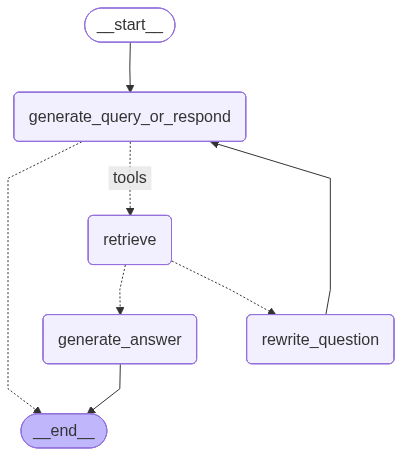

In [31]:
graph

In [32]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is the fee structure for btech?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_gUFAbWCLBySN7T4iE9reszRm)
 Call ID: call_gUFAbWCLBySN7T4iE9reszRm
  Args:
    query: BTech fee structure



📊 Document relevance grade: yes
Update from node retrieve
================================= Tool Message =================================
Name: retrieve_blog_posts

Tuition Fee Structure 
Program Branch Fee Per Semester Duration 
BTech Computer Sc. 
Engineering (AI & 
Machine Learning) 
150000 4 Years 
BTech Computer Sc. 
Engineering (Data 
Science) 
145000 4 Years 
BTech Computer Sc. 
Engineering (IoT & 
Cyber Security) 
145000 4 Years 
BTech Computer Science 
and Engineering 
145000 4 Years 
BTech Computer Sc. & IT 145000 4 Years 
BTech Robotics and 
Artificial 
Intelligence 
145000 4 Years 
BTech Artificial 
Intelligence and 
Data Science 
145000 4 Years 
BTech Electronic & 
Communication 
Engineering 
125000 4 Yea